# Проверка используемых библиотек

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

numpy 1.18.5
pandas 1.1.4
scipy 1.5.4
sklearn 0.19.0
lightgbm 3.1.0


**Важно!** Корректный ответ протестирован только на библиотеках следующих версий:

    numpy 1.13.1
    pandas 0.20.3
    scipy 0.19.1
    sklearn 0.19.0
    ligthgbm 2.0.6

# Компоновка

В этой задаче требуется реализовать 2 схемы компоновки моделей: простую линейную и стекинг. 

Сначала добавим некоторые вспомогательные функции.

In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


# Как мы помним, по-умолчанию pandas хранит целые и дробные числа с точностью 64 бита
# Нам такая точность не нужна, поэтому напишем функцию, которая, принимая на входе выборку,
# возвращает ее на выходе с 32-битными числами
def downcast_dtypes(df):
    '''
        Меняем типы полей в датафрейме: 
                
                `float64` на `float32`
                `int64`   на `int32`
    '''
    
    # Выбираем поля к преобразованию в 32-битные
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Проводим преобразование
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Грузим исходные данные

In [3]:
#!curl -Ls -o ../readonly/final_project_data/sales_train.csv.gz --create-dirs https://github.com/Brandon-HY-Lin/coursera_How-to-Win-a-Data-Science-Competition-Learn-from-Top-Kagglers/blob/master/readonly/final_project_data/sales_train.csv.gz?raw=true
#!curl -Ls -o ../readonly/final_project_data/shops.csv --create-dirs https://github.com/Brandon-HY-Lin/coursera_How-to-Win-a-Data-Science-Competition-Learn-from-Top-Kagglers/blob/master/readonly/final_project_data/shops.csv?raw=true
#!curl -Ls -o ../readonly/final_project_data/items.csv --create-dirs https://github.com/Brandon-HY-Lin/coursera_How-to-Win-a-Data-Science-Competition-Learn-from-Top-Kagglers/blob/master/readonly/final_project_data/items.csv?raw=true
#!curl -Ls -o ../readonly/final_project_data/item_categories.csv --create-dirs https://github.com/Brandon-HY-Lin/coursera_How-to-Win-a-Data-Science-Competition-Learn-from-Top-Kagglers/blob/master/readonly/final_project_data/item_categories.csv?raw=true

In [3]:
#sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
#shops = pd.read_csv('../readonly/final_project_data/shops.csv')
#items = pd.read_csv('../readonly/final_project_data/items.csv')
#item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')

sales_train = pd.read_csv('../data/sales_train.csv.gz')
sales_test = pd.read_csv('../data/test.csv.gz')
items = pd.read_csv('../data/items.csv')
item_categories = pd.read_csv('../data/item_categories.csv')
shops = pd.read_csv('../data/shops.csv')

Упростим задачу, оставив только 3 магазина

In [4]:
#sales = sales[sales['shop_id'].isin([26, 27, 28])]
sales_train.sort_values(['date', 'shop_id', 'item_id']).head(20)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
32569,01.01.2013,0,2,991,99.0,1.0
32552,01.01.2013,0,2,1472,2599.0,1.0
32632,01.01.2013,0,2,1905,249.0,1.0
32459,01.01.2013,0,2,2920,599.0,2.0
32504,01.01.2013,0,2,3320,1999.0,1.0
32865,01.01.2013,0,2,4464,599.0,1.0
32833,01.01.2013,0,2,4724,1399.0,1.0
32747,01.01.2013,0,2,5649,2190.0,1.0
32358,01.01.2013,0,2,6911,599.0,1.0
32099,01.01.2013,0,2,6916,999.5,1.0


А что такое date_block_num? Можно предположить, что это сдвиг месяца относительно начала временного ряда. В любом случае лучше проверить.

In [5]:
pd.DataFrame(sales_train[['date_block_num', 'date']].groupby('date_block_num').aggregate(['min', 'max'])['date'])

,min,max
date_block_num,,
0,01.01.2013,31.01.2013
1,01.02.2013,28.02.2013
2,01.03.2013,31.03.2013
3,01.04.2013,30.04.2013
4,01.05.2013,31.05.2013
5,01.06.2013,30.06.2013
6,01.07.2013,31.07.2013
7,01.08.2013,31.08.2013
8,01.09.2013,30.09.2013


Похоже, гипотеза была верна: date_block_num - это сквозной порядковый номер месяца для всего временного ряда, начинающийся с нуля.

# Преобразуем исходные данные в таблицу, с которой будем работать

Очевидно, что данные по временным рядам, к которым относятся и наши продажи, зачастую содержат пропуски для некоторых моментов времени. Нам надо избавиться от этой проблемы. Для этого надо преобразовать исходный ряд продаж в такой, где не будет пропущенных значений. То есть, нам нужна таблица, где будут записи для каждого магазина для каждого товара для каждого месяца.

Инициализируем поля, по которым надо перечислить все уникальные значения:

In [6]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

Для каждого дня создадим таблицу со всеми теоретически возможными комбинациями пар магазин-товар по этому месяцу.

In [7]:
grid = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train.loc[sales_train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_train.loc[sales_train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [9]:
grid.shape

(278619, 3)

Теперь нам надо перевести ежедневные данные по продажам в ежемесячные. Сначала повторно посмотрим на наши ежедневные данные:

In [8]:
sales_train.head(20)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [25]:
#sales_train.groupby(index_cols, as_index=False).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day': 'target'})
#sales_train.groupby(index_cols, as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day': 'target'}).head()
sales_train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day':'target_shop'})

,shop_id,date_block_num,target_shop
0,0,0,5578.0
1,0,1,6127.0
2,1,0,2947.0
3,1,1,3364.0
4,2,0,1146.0
...,...,...,...
1581,59,29,913.0
1582,59,30,992.0
1583,59,31,1214.0
1584,59,32,914.0


In [20]:
grid

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
...,...,...,...
10913845,21,7635,33
10913846,21,7638,33
10913847,21,7640,33
10913848,21,7632,33


In [26]:
# Считаем суммарные продажи каждого товара в каждом магазине за каждый месяц
gb = sales_train.groupby(index_cols, as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day': 'target'})
# И присоединяем полученную таблицу к созданной ранее таблице с всеми товарами по всем магазинам за все месяцы
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Аналогичным образом добавляем суммы продаж всех товаров за месяц по каждому магазину
sales_train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum().rename(columns={'item_cnt_day':'target_shop'})
#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Аналогичным образом добавляем суммы продаж каждого товара по всем магазинам за месяц
gb = sales_train.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
#gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

all_data.head(10)

MemoryError: Unable to allocate 85.1 GiB for an array with shape (11428259986,) and data type int64

In [12]:
# Экономим память
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

Добавим новые признаки, посчитав имеющиеся количественные показатели по состоянию на [1, 2, 3, 4, 5, 12] месяцев назад.

In [13]:
# Собираем поля, на основании которых добавим показатели прошлых периодов
# Это все таблицы all_data поля за исключением тех, что приведены в списке index_cols
cols_to_rename = list(all_data.columns.difference(index_cols)) 
cols_to_rename

['target', 'target_item', 'target_shop']

In [14]:
shift_range = [1, 2, 3, 4, 5, 12]
for month_shift in tqdm_notebook(shift_range):
    # Создаем временную таблицу для расчета данных, сдвинутых на какой-то один период из обозначенных в shift_range шести
    train_shift = all_data[index_cols + cols_to_rename].copy()
    # Заполняем значения месяцев сдвига, одновременно беря ту часть исходной таблицы, 
    # которая соответствует нужному нам сдвигу. Смысл сдвига состоит в том, чтобы запись исходной таблицы обозначенным 
    # там date_block_num содержала на самом деле данные не за месяц date_block_num, а за date_block_num + month_shift
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    # Делаем функцию, которая во временной таблице для расчета данных переименует столбцы со сдвинутыми данными так,
    # чтобы сдвиг был понятен из названия столбца
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    # Объединяем временную таблицу с исходной
    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [15]:
all_data.head(10)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
0,28,7738,0,4.0,7057.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28,7737,0,10.0,7057.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28,7770,0,6.0,7057.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,7664,0,1.0,7057.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,7814,0,2.0,7057.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,28,7815,0,2.0,7057.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,28,7820,0,4.0,7057.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,28,7672,0,1.0,7057.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,28,7536,0,9.0,7057.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,28,7448,0,7.0,7057.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'target_lag_1', 'target_item_lag_1', 'target_shop_lag_1',
       'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2',
       'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3',
       'target_lag_4', 'target_item_lag_4', 'target_shop_lag_4',
       'target_lag_5', 'target_item_lag_5', 'target_shop_lag_5',
       'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12'],
      dtype='object')

In [17]:
# Не используем старые данные от 2013 года
all_data = all_data[all_data['date_block_num'] >= 12] 

# Сохраним список добавленных полей со сдвигами, чтобы потом удалить их при обучении модели
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Удалим ненужные категориальные признаки
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [18]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'target_shop',
       'target_item', 'target_lag_1', 'target_item_lag_1', 'target_shop_lag_1',
       'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2',
       'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3',
       'target_lag_4', 'target_item_lag_4', 'target_shop_lag_4',
       'target_lag_5', 'target_item_lag_5', 'target_shop_lag_5',
       'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12',
       'item_category_id'],
      dtype='object')

Теперь у нас в переменной `all_data` есть матрица исходных признаков. Что она из себя представляет:

In [19]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
2,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
3,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


# Делим данные на обучающую и тестовую выборки

Тестовой выборкой будет последний месяц

In [20]:
# Отдельно сохраним значения поля date_block_num, т.к. мы не можем использовать в исходных признаках, 
# однако он пригодится при создании итоговых данных
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [21]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

# Модели первого уровня

Нам надо здесь реализовать базовую стекинговую схему. Имея здесь временной компонент будем пользоваться ***схему f)*** из исходного материала для изучения. Помним, что мы используем модели первого уровня для построения двух наборов данных: тестовые мета-признаки и обучающие мета-признаки второго уровня. Посмотрим сначала на создание тестовых мета-признаков.

**f) K-Fold схема во временных рядах**

В задачах на временные ряды имеются данные за какой-то период времени и требуется спрогнозировать значения на какой-то период в будущем (день, неделя, месяц и т.д.). Обозначим длительность этого периода как T.

1) Последовательно разбиваем обучающие данные на подмножества, размер каждого из которых равен T. Выбираем первые M подмножеств.

2) Обучаем N различных моделей на этих M подмножествах и предсказываем значения подмножества M + 1. Потом обучаем эти модели на M + 1 подмножествах и предсказываем значения подномжества M + 2 и так далее, пока не достигнем конца обучающей выборки. После этого обучаем наши N моделей на всей обучающей выборке и предсказываем значения тестовой выборки. Так мы получаем прогнозы (т.е. мета-признаки) для части обучающей выборки начиная с M + 1 и для тестовой выборки.

3) Используя мета-признаки для K подмножеств обучающей выборки (M + 1, M + 2, ..., M + K), чтобы построить на них модель и провалидировать ее на подмножестве M + K + 1. Возвращаемся таким образом к шагу 1, оперируя меньшим числом подмножеств и мета-признаками вместо исходных признаков.

### Тестовые мета-признаки

Сначала используем линейную регрессию из sklearn чтобы получить прогнозы для последнего месяца.

In [22]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.743180


А теперь посчитаем то же самое с помощью *LightGBM*.

In [23]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.738391


Объединим результаты прогноза для получения признаков на вход модели следующего уровня.

In [24]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 
X_test_level2

array([[ 13.45896153,  13.37831474],
       [  3.18599444,   2.55590212],
       [  2.5028209 ,   1.52356814],
       ..., 
       [  0.69860529,   0.41663964],
       [  0.12072911,   0.34056468],
       [  0.1755516 ,   0.32987826]])

### Получаем мета-признаки

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

Как и говорилось, реализуем **f)**. В нашем случае T = 1 мес, а M = 15. То есть, нам надо получить прогнозы с помощью `lr` и `lgb`, используя те же параметры, что и в моделях выше.

In [25]:
dates_train.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32], dtype=int64)

In [26]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [27]:
y_train_level2.shape

(34404,)

In [28]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
2,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
3,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


In [29]:
dates.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33], dtype=int64)

In [30]:
dates_train.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32], dtype=int64)

In [31]:
all_data_train = all_data.loc[all_data['date_block_num'] < 27]

In [32]:
cur_block_num = 27

#X_train = all_data.loc[all_data['date_block_num'] <  cur_block_num].drop(to_drop_cols, axis=1)
#X_test =  all_data.loc[all_data['date_block_num'] == cur_block_num].drop(to_drop_cols, axis=1)

#y_train = all_data.loc[all_data['date_block_num'] <  cur_block_num, 'target'].values
#y_test =  all_data.loc[all_data['date_block_num'] == cur_block_num, 'target'].values

In [33]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in tqdm_notebook([27, 28, 29, 30, 31, 32]):
    
    print(cur_block_num, end='')
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    X_train_block = all_data.loc[dates < cur_block_num].drop(to_drop_cols, axis=1)
    X_test_block = all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)
    
    y_train_block = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_block = all_data.loc[dates == cur_block_num, 'target'].values
    
    print(':  X_train_block.shape={}'.format(X_train_block.shape), end='')
    print(',  X_test_block.shape={}'.format(X_test_block.shape), end='')
    print(',   Total Size={}'.format(X_train_block.shape[0] + X_test_block.shape[0]), end='')
    print()
    
    lr.fit(X_train_block, y_train_block)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr.predict(X_test_block.values)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_block, label=y_train_block), 100)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(X_test_block)
    
    
# Sanity check
assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


27:  X_train_block.shape=(120192, 21),  X_test_block.shape=(6438, 21),   Total Size=126630
28:  X_train_block.shape=(126630, 21),  X_test_block.shape=(6804, 21),   Total Size=133434
29:  X_train_block.shape=(133434, 21),  X_test_block.shape=(6693, 21),   Total Size=140127
30:  X_train_block.shape=(140127, 21),  X_test_block.shape=(6474, 21),   Total Size=146601
31:  X_train_block.shape=(146601, 21),  X_test_block.shape=(3618, 21),   Total Size=150219
32:  X_train_block.shape=(150219, 21),  X_test_block.shape=(4377, 21),   Total Size=154596



In [34]:
X_train_level2.mean(axis=0)

array([ 1.50148988,  1.38811989])

Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

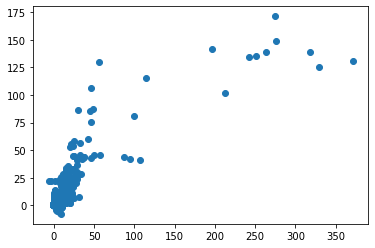

In [35]:
# YOUR CODE GOES HERE
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [36]:
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
r2_scores = np.array([r2_score(y_train_level2, np.dot(X_train_level2, [alpha, 1 - alpha])) for alpha in alphas_to_try])
best_alpha = alphas_to_try[r2_scores.argmax()] # YOUR CODE GOES HERE
r2_train_simple_mix = r2_scores.max() # YOUR CODE GOES HERE

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.765000; Corresponding r2 score on train: 0.627255


Now use the $\alpha$ you've found to compute predictions for the test set 

In [37]:
test_preds = best_alpha * pred_lr + (1 - best_alpha) * pred_lgb # YOUR CODE GOES HERE
r2_test_simple_mix = r2_score(y_test, test_preds) # YOUR CODE GOES HERE

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.781144


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [38]:
# YOUR CODE GOES HERE
lr.fit(X_train_level2, y_train_level2)

print('Ratio value:            {}'.format(lr.coef_))
print('Normalized Ratio value: {}'.format(lr.coef_ / lr.coef_.sum()))

Ratio value:            [ 0.80576806  0.09755171]
Normalized Ratio value: [ 0.89200755  0.10799245]


Compute R-squared on the train and test sets.

In [39]:
train_preds = lr.predict(X_train_level2) # YOUR CODE GOES HERE
r2_train_stacking = r2_score(y_train_level2, train_preds) # YOUR CODE GOES HERE

test_preds = lr.predict(np.vstack((pred_lr, pred_lgb)).T) # YOUR CODE GOES HERE
r2_test_stacking = r2_score(y_test, test_preds) # YOUR CODE GOES HERE

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.632176
Test  R-squared for stacking is 0.771297


Interesting, that the score turned out to be lower than in previous method. Although the model is very simple (just 3 parameters) and, in fact, mixes predictions linearly, it looks like it managed to overfit. **Examine and compare** train and test scores for the two methods. 

And of course this particular case does not mean simple mix is always better than stacking.

We all done! Submit everything we need to the grader now.

In [42]:
from grader import Grader
grader = Grader()

grader.submit_tag('best_alpha', best_alpha)

grader.submit_tag('r2_train_simple_mix', r2_train_simple_mix)
grader.submit_tag('r2_test_simple_mix',  r2_test_simple_mix)

grader.submit_tag('r2_train_stacking', r2_train_stacking)
grader.submit_tag('r2_test_stacking',  r2_test_stacking)

Current answer for task best_alpha is: 0.765
Current answer for task r2_train_simple_mix is: 0.627255043446
Current answer for task r2_test_simple_mix is: 0.781144169579
Current answer for task r2_train_stacking is: 0.632175561459
Current answer for task r2_test_stacking is: 0.771297132342


In [43]:
STUDENT_EMAIL = 'directe@list.ru' # EMAIL HERE
STUDENT_TOKEN = 'GFdJ4bpS10VarPF4'# TOKEN HERE
grader.status()

You want to submit these numbers:
Task best_alpha: 0.765
Task r2_train_simple_mix: 0.627255043446
Task r2_test_simple_mix: 0.781144169579
Task r2_train_stacking: 0.632175561459
Task r2_test_stacking: 0.771297132342


In [44]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
